In [6]:
import sklearn
import pandas as pd
import numpy as np
import math
import warnings
from scipy.stats import zscore
# plotting
import seaborn as sns
from matplotlib import pyplot 
import matplotlib.pyplot as plt
sns.set(context='paper', style='whitegrid', rc={'figure.facecolor':'white'}, font_scale=1.2)

# preproc
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer

# modeling
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

# grid search CV 
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold

# metrics for classification
from sklearn.metrics import roc_curve,  precision_recall_curve
from sklearn.metrics import auc,  roc_auc_score, recall_score, precision_score, accuracy_score, f1_score, log_loss
from sklearn.metrics import classification_report, confusion_matrix 

# import custom functions
import sys
sys.path.append("../")
from projectname import custom_funcs

# SET GLOBAL
RANDOM = 0
TEST_SIZE = 0.2
KEY_THRESH = 0.35

def get_cm_info (cm, y_test):
    """print out summary of confusion matrix interpretation"""
    true_negatives = cm[0,0]
    false_negatives = cm[1,0]
    true_positives = cm[1,1]
    false_positives = cm[0,1]
    total_cases = y_test.shape[0]

    true_negative_prop = true_negatives / total_cases
    true_positive_prop = true_positives/ total_cases 
    print("True negatives identified: Proportion of sample correctly identified  as low risk, no biopsy necessary: {}".format(round(true_negative_prop,2)))
    print("True positives identified: Proportion of sample correctly classified as high risk, need biopsy: {}".format(round(true_positive_prop, 2)))

    
    false_negative_rate = round(false_negatives / (true_positives + false_negatives),2)
    false_positive_rate = round(false_positives / (false_positives + true_negatives),2)
   
    recall = round(true_positives / (false_negatives + true_positives),2)
    precision = round(true_positives / (false_positives + true_positives),2)
    npp = round(true_negatives/ (true_negatives + false_negatives),2)
    specificity =  round(true_negatives/  (true_negatives + false_positives), 2)
   
     
    print ("\n Recall / Sensitivity: \n Of all people who actually have metastasis, how many are correctly recommended for biopsy? {}".format(round(recall, 2)))
    print("False negative rate: \n Patients mis-classified as low risk, but need biopsy: {}".format(round(false_negative_rate, 2)))

    print('\n Specificity/True negative rate: \n Of people who are actually low risk, how many are classified as low risk?', format(specificity))
    print("False positive rate: \n Patients classifiedas high risk, but don't need biopsy: {}".format(round(false_positive_rate,2)))

    
    print ("\n Precision / Positive Predictive Value: \n Of all people recommended for biopsy, how many actually have metastasis? {}".format(round(precision, 2)))
    print('Negative Predictive Value: \n Of people classified as low risk,  how many are actually low risk? {}'.format(round(npp)))


## 1. Prep data

- load data 
- select subset of features to include
- split data into train-val and hold-out test sets 


In [7]:
# OPEN DATA with all cases 
df = pd.read_csv("../data/cleaned/NCDB_cleaned_all_cases.csv")

# select features to include  
df_selected = df [['AGE', 'lymph_vasc_invasion',  'tumor_size_bins_cm', 'metastasis']]
df_selected['AGE'] = df_selected.AGE.astype('float64')
df_selected.shape[0]

/Users/michellevantieghem2/.conda/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


14948

### Make dataset with listwise deletion
- only include complete cases 

In [8]:
#drop extra stuff
df_drop = df_selected.dropna(axis = 0)
outcome_drop = df_drop[['metastasis']]
features_drop = df_drop.drop(columns =['metastasis'])
df_drop.shape[0]


4128

### Make dataset to impute tumor size
- not imputing metastasiis or lymph vasc invasion, too much missing data


In [9]:
df_impute = df_selected[(df_selected['metastasis'].isnull()== False) 
                        & (df_selected.lymph_vasc_invasion.isnull() == False)]

outcome_impute = df_impute[['metastasis']]
features_impute = df_impute.drop(columns =['metastasis'])

print("Number of values to impute: %1.f" % df_impute.tumor_size_bins_cm.isnull().sum())

Number of values to impute: 519


### Import MICE-imputed data 
- imputed data in R, treat like complete cases


In [10]:
df_MICE = pd.read_csv("../data/processed/NCDB_MICE_imputed.csv")
df_MICE['AGE'] = df_MICE.AGE.astype('float64')
outcome_MICE = df_MICE[['metastasis']]
features_MICE = df_MICE.drop(columns =['metastasis'])
df_MICE.shape[0]


4647

## 2. Set up preprocessing
- iterative imputer and KNN to impute missing cases for tumor size 
- standard scale (zscore) continuous features

In [11]:
# DEFINE PREPROCESSING 
num_features = ['AGE', 'tumor_size_bins_cm']
from sklearn.impute import KNNImputer

# Build a preprcessing pipeline for numeric variables
# apply imputation first, then standardize.
# will only impute tumor depth since that's what is missing.
KNN_pipeline = Pipeline(steps=[
    ('KNNImputer', KNNImputer(n_neighbors = 2)),
    ('std_scaler', StandardScaler())])

# Instantiate a preprocessor
KNN_preprocessor = ColumnTransformer(
    transformers=[
    ("num", KNN_pipeline, num_features)],
    remainder = 'passthrough')


II_pipeline= Pipeline(steps=[
    ('IterativeImputer',IterativeImputer()),
    ('std_scaler', StandardScaler())])

II_preprocessor = ColumnTransformer(
    transformers=[
    ("num", II_pipeline, num_features)],
    remainder = 'passthrough')

# pipeline just applies standard scalng and nothing else!
SS_pipeline = Pipeline(steps = [
     ('std_scaler', StandardScaler())])

SS_preprocessor = ColumnTransformer(
    transformers = [
        ('num', SS_pipeline, num_features)],
    remainder = 'passthrough')

### Check imputation output

In [12]:
# Generate the preprocessor to check the output 
II_preprocessed_X = II_preprocessor.fit_transform(features_impute)
II_check_preproc = pd.DataFrame(II_preprocessed_X)


KNN_preprocessed_X = KNN_preprocessor.fit_transform(features_impute)
KNN_check_preproc = pd.DataFrame(KNN_preprocessed_X)

compare = pd.concat([II_check_preproc[1], KNN_check_preproc[1], features_MICE.tumor_size_bins_cm], axis = 1)
compare.columns = ['II', 'KNN', 'MICE']
compare.II.min()

-0.22986778267774022

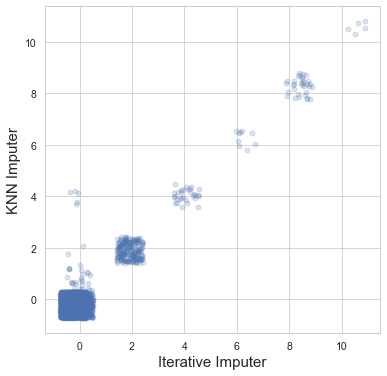

In [13]:
## PROBLEM: IMPUTER GIVING NEGATIVE VALUES.
plt.figure(figsize = (6,6))
sns.regplot(x = 'II', y = 'KNN', data = compare,  fit_reg = False,
            scatter_kws = {'alpha' : 0.2},
            x_jitter = 0.5, y_jitter = 0.5)
plt.xlabel("Iterative Imputer", size = 15)
plt.ylabel("KNN Imputer", size = 15)
plt.show()

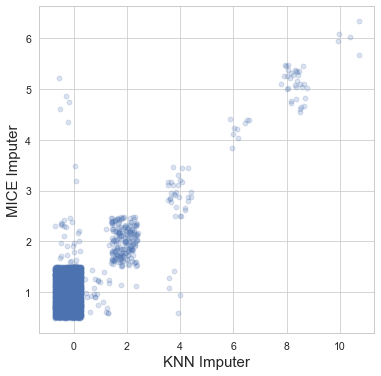

In [14]:
plt.figure(figsize = (6,6))
sns.regplot(x = 'KNN', y = 'MICE', data = compare,  fit_reg = False,
            scatter_kws = {'alpha' : 0.2},
            x_jitter = 0.5, y_jitter = 0.5)
plt.xlabel("KNN Imputer", size = 15)
plt.ylabel("MICE Imputer", size = 15)
plt.show()

## Set up cross validation folds
- stratified based on outcome (metastasis, binary class)
- stratified CV folds based on outcome variable  (metastsis)
- 5 CV folds repeated 5x with random sampling

In [16]:
# split into train-test split for incomplte data to be imputed in sklearn
X_trainval_impute, X_test_impute, y_trainval_impute, y_test_impute = train_test_split(features_impute,
                                                          outcome_impute,
                                                          random_state = 0)
# set data with only complete cases (droped NAs)
X_trainval_drop, X_test_drop, y_trainval_drop, y_test_drop = train_test_split(features_drop,
                                                                             outcome_drop,
                                                                             random_state = 0)

# set data from MICE imputation
X_trainval_MICE, X_test_MICE, y_trainval_MICE, y_test_MICE = train_test_split(features_MICE, 
                                                                             outcome_MICE,
                                                                             random_state = 0)
# make cross val folds
CV_folds =  RepeatedStratifiedKFold(n_splits = 3, 
                                    n_repeats =  5,  
                                    random_state = 0)

## 3. Set up models 
###  Logistic Regression Variants
Testing three linear logistic reg variants: 
- L1 regularization = lasso (coefficients shrunk to zero, feature selection)
- L2 regularization = ridge (coefficients shrink to tiny sizes) *default l2, C = 0.1*
- elastic net = best of both 

Other notes:
- Solver = 'saga' because it supports all 3 model types
- Maintaining the balanced weights moving forward
- increasing max number of iterations to 1000 so models converge

### SVM
- because why not 
- need a better reason here.

### Random forest
- allows for non-linear interactions between features
- might have advantage given bootstrap sampling...
- usually just does better.

In [22]:
# DEFINE MODELS 

Logistic = LogisticRegression(class_weight = 'balanced', 
                              max_iter = 1000,
                              penalty = 'none', 
                              solver = 'saga', 
                             random_state = RANDOM)
SVM = SVC (kernel = "rbf",
          class_weight = 'balanced',
          probability = True,
          random_state = RANDOM)

DT = DecisionTreeClassifier(class_weight = "balanced",
                           random_state = RANDOM)
RF = RandomForestClassifier(class_weight = 'balanced',
                           random_state = RANDOM)

### Define pipelines for preproc, applied to each CV fold 
- pipelines to apply KNN imputation or iterative imputation
- separate pipeline for no imputation, to be applied to complete cases and MICE data


In [23]:
## KNN imputation
Logit_KNN = Pipeline(steps = [('KNN_impute', KNN_preprocessor),
                              ('model', Logistic)])
SVM_KNN = Pipeline(steps = [('KNN_impute', KNN_preprocessor),
                             ('model', SVM)])
RF_KNN = Pipeline(steps = [('KNN_impute', KNN_preprocessor),
                            ('model', RF)])
DT_KNN = Pipeline(steps = [('KNN_impute', KNN_preprocessor),
                            ('model', DT)])
## iterative imputation
Logit_II = Pipeline(steps = [('II_impute', II_preprocessor),
                              ('model', Logistic)])
SVM_II = Pipeline(steps = [('II_impute', II_preprocessor),
                             ('model', SVM)])
RF_II = Pipeline(steps = [('II_impute', II_preprocessor),
                            ('model', RF)])

DT_II = Pipeline(steps = [('II_impute', II_preprocessor),
                            ('model', DT)])

## APPLY Standard scaling only (no imputation)
Logistic_SS = Pipeline(steps = [('Scale', SS_preprocessor),
                              ('model', Logistic)])
SVM_SS = Pipeline(steps = [('Scale', SS_preprocessor),
                              ('model', SVM)])
RF_SS = Pipeline(steps = [('Scale', SS_preprocessor),
                            ('model', RF)])
DT_SS = Pipeline(steps = [('Scale', SS_preprocessor),
                            ('model', DT)])

## 4.  Fit models with grid search  CV

###  Define hyper-parameters
For linear models 
- tuning the amount of penalization / lambda/ C
- larger C = less regularization
- smaller C = more regularization (more coefficients to zero)
- default Logistic Regression in sklearn has C = 0.1, l2 regularization (ridge)

For Random forest
- tuning minimum samples per leaf 
- controls tree depth

In [24]:
## DEFINE SCORES for grid search
score_list = {'acc': 'accuracy',
              'precision' : 'precision',
              'recall': 'recall', 
               'f1': 'f1',
              'roc_auc': 'roc_auc'}

In [52]:
# larger C = less regularization
# default = 1.0 
param_grid_C = {'model__C': [0.001, 0.01, 0.1, 1, 10, 100] }
param_grid_tree = { #'max_depth': [25, 50, 75, 100], # max depth of the tree
                 'model__min_samples_leaf' : [1, 2, 5], # minimum samples contained at each end node
                 'model__min_samples_split': [2, 5, 10, 15, 20] # how small is  a node allowed to be before it's split
               }
param_grid_RF = { #'max_depth': [25, 50, 75, 100], # max depth of the tree
                 'model__min_samples_leaf' : [1, 2, 5], # minimum samples contained at each end node
                 'model__min_samples_split': [2, 5, 10, 15, 20] # how small is  a node allowed to be before it's split
               #  'model__n_estimators': [200, 500, 1000] # number of trees - hw many resampled iterations.
               }

### Define grids for KNN + Iterative imputation

In [53]:
# there is actually no penalty so this souldn't work. 
Logit_KNN_grid = GridSearchCV(Logit_KNN,
                    param_grid = param_grid_C, 
                    return_train_score = True,
                    cv = CV_folds, 
                    scoring = score_list,
                    refit = "precision",
                    n_jobs =  -1)

SVM_KNN_grid = GridSearchCV(SVM_KNN,
                    param_grid = param_grid_C,
                    return_train_score = True,
                    cv = CV_folds, 
                    scoring = score_list,
                    refit = "recall",
                    n_jobs =  -1)

DT_KNN_grid = GridSearchCV(DT_KNN,
                     param_grid = param_grid_tree,
                    return_train_score = True,
                    cv = CV_folds, 
                    scoring = score_list,
                    refit = "recall",
                    n_jobs =  -1)

RF_KNN_grid = GridSearchCV(RF_KNN,
                    param_grid = param_grid_RF,
                    return_train_score = True,
                    cv = CV_folds, 
                    scoring = score_list,
                    refit = "recall",
                    n_jobs =  -1)

##### Iterative Imputer 
Logit_II_grid = GridSearchCV(Logit_II,
                    param_grid = param_grid_C, 
                    return_train_score = True,
                    cv = CV_folds, 
                    scoring = score_list,
                    refit = "precision",
                    n_jobs =  -1)

SVM_II_grid = GridSearchCV(SVM_II,
                    param_grid = param_grid_C,
                    return_train_score = True,
                    cv = CV_folds, 
                    scoring = score_list,
                    refit = "recall",
                    n_jobs =  -1)


DT_II_grid = GridSearchCV(DT_II,
                     param_grid = param_grid_tree,
                    return_train_score = True,
                    cv = CV_folds, 
                    scoring = score_list,
                    refit = "recall",
                    n_jobs =  -1)

RF_II_grid = GridSearchCV(RF_II,
                    param_grid = param_grid_RF,
                    return_train_score = True,
                    cv = CV_folds, 
                    scoring = score_list,
                    refit = "recall",
                    n_jobs =  -1)



###  Run loop for each  imputation grid

In [54]:

# list of names, KNN first 
classifier_names = ['Logistic Regression', 'Support Vector Machine', 'Decision Tree', 'Random Forest',
                    'Logistic Regression', 'Support Vector Machine', 'Decision Tree', 'Random Forest']
                    
imputation_names =  ['KNN', 'KNN', 'KNN', 'KNN',
                    'II', 'II', 'II', 'II']
# list of pipelines for each model
classifiers = [Logit_KNN_grid, SVM_KNN_grid, DT_KNN_grid, RF_KNN_grid,  
               Logit_II_grid, SVM_II_grid, DT_II_grid, RF_II_grid]

# fit each grid and save metrics.
i = 0
grid_results = pd.DataFrame()
for classifier in classifiers:
    classifier.fit(X_trainval_impute, y_trainval_impute)
    # get the results and store them!
    results = pd.DataFrame(classifier.cv_results_)
    results['model'] = classifier_names[i]
    results['imputation'] = imputation_names[i]
    print(classifier_names[i])
    print(results.shape)
    i = i + 1
    grid_results = pd.concat([grid_results, results], ignore_index = True)
    


/Users/michellevantieghem2/.conda/envs/insight/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/Users/michellevantieghem2/.conda/envs/insight/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Logistic Regression
(6, 183)


/Users/michellevantieghem2/.conda/envs/insight/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Support Vector Machine
(6, 183)
Decision Tree
(15, 184)


/Users/michellevantieghem2/.conda/envs/insight/lib/python3.7/site-packages/sklearn/pipeline.py:335: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


Random Forest
(15, 184)


/Users/michellevantieghem2/.conda/envs/insight/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/Users/michellevantieghem2/.conda/envs/insight/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Logistic Regression
(6, 183)


/Users/michellevantieghem2/.conda/envs/insight/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Support Vector Machine
(6, 183)
Decision Tree
(15, 184)
Random Forest
(15, 184)


/Users/michellevantieghem2/.conda/envs/insight/lib/python3.7/site-packages/sklearn/pipeline.py:335: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


In [55]:
#grid_results['imputation'] = grid_results.model.apply(lambda x: "KNN" if "KNN" in x else "II")
grid_results.imputation.value_counts()

KNN    48
II     36
Name: imputation, dtype: int64

### define grids for complete cases and MICE data
- preprocessing is only for standard scaling of continous variables.

In [58]:
# NO imputer 
Logit_grid = GridSearchCV(Logistic_SS,
                    param_grid = param_grid_C, 
                    return_train_score = True,
                    cv = CV_folds, 
                    scoring = score_list,
                    refit = "precision",
                    n_jobs =  -1)

SVM_grid = GridSearchCV(SVM_SS,
                    param_grid = param_grid_C,
                    return_train_score = True,
                    cv = CV_folds, 
                    scoring = score_list,
                    refit = "recall",
                    n_jobs =  -1)

DT_grid = GridSearchCV(DT_SS,
                     param_grid = param_grid_tree,
                    return_train_score = True,
                    cv = CV_folds, 
                    scoring = score_list,
                    refit = "recall",
                    n_jobs =  -1)

RF_grid = GridSearchCV(RF_SS,
                    param_grid = param_grid_RF,
                    return_train_score = True,
                    cv = CV_folds, 
                    scoring = score_list,
                    refit = "recall",
                    n_jobs =  -1)


### Run loop for each grid with complete cases

In [60]:
classifier_names = ['Logistic Regression', 'Support Vector Machine', 'Decision Tree', 'Random Forest']
# list of pipelines for each model
classifiers = [Logit_grid, SVM_grid, DT_grid, RF_grid] # RF grid

# Run for complete cases
i = 0
drop_grid_results = pd.DataFrame()
for classifier in classifiers:
    classifier.fit(X_trainval_drop, y_trainval_drop)
    # get the results and store them!
    results = pd.DataFrame(classifier.cv_results_)
    results['model'] = classifier_names[i]
    print(classifier_names[i])
    print(results.shape)
    i = i + 1
    drop_grid_results = pd.concat([drop_grid_results, results], ignore_index = True)

/Users/michellevantieghem2/.conda/envs/insight/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/Users/michellevantieghem2/.conda/envs/insight/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Logistic Regression
(6, 182)


/Users/michellevantieghem2/.conda/envs/insight/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Support Vector Machine
(6, 182)
Decision Tree
(15, 183)


/Users/michellevantieghem2/.conda/envs/insight/lib/python3.7/site-packages/sklearn/pipeline.py:335: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


Random Forest
(15, 183)


### Run loop for MICE imputetd data

In [61]:

## run for MICE dta
i = 0
MICE_grid_results = pd.DataFrame()
for classifier in classifiers:
    classifier.fit(X_trainval_MICE, y_trainval_MICE)
    # get the results and store them!
    results = pd.DataFrame(classifier.cv_results_)
    results['model'] = classifier_names[i]
    print(classifier_names[i])
    print(results.shape)
    i = i + 1
    MICE_grid_results = pd.concat([MICE_grid_results, results], ignore_index = True)



/Users/michellevantieghem2/.conda/envs/insight/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/Users/michellevantieghem2/.conda/envs/insight/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Logistic Regression
(6, 182)


/Users/michellevantieghem2/.conda/envs/insight/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Support Vector Machine
(6, 182)
Decision Tree
(15, 183)
Random Forest
(15, 183)


/Users/michellevantieghem2/.conda/envs/insight/lib/python3.7/site-packages/sklearn/pipeline.py:335: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


### COMBINE ALL GRID RESULTS and organize them


In [75]:
drop_grid_results['imputation'] = 'None'
MICE_grid_results['imputation'] = 'MICE'
drop_grid_results.shape

giant_grid_results = pd.concat([grid_results, drop_grid_results, MICE_grid_results], ignore_index = True)
giant_grid_results.imputation.value_counts()

giant_grid_results[giant_grid_results.imputation == "KNN"].model.value_counts()
giant_grid_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__C,params,split0_test_acc,split1_test_acc,split2_test_acc,split3_test_acc,...,split11_train_roc_auc,split12_train_roc_auc,split13_train_roc_auc,split14_train_roc_auc,mean_train_roc_auc,std_train_roc_auc,model,imputation,param_model__min_samples_leaf,param_model__min_samples_split
0,0.065718,0.018539,0.066746,0.010090,0.001,{'model__C': 0.001},0.652324,0.639415,0.648579,0.637694,...,0.657547,0.652671,0.648381,0.644451,0.648916,0.00571,Logistic Regression,KNN,NaN,NaN
1,0.060694,0.008582,0.064790,0.004902,0.01,{'model__C': 0.01},0.652324,0.639415,0.648579,0.637694,...,0.657547,0.652671,0.648381,0.644451,0.648916,0.00571,Logistic Regression,KNN,NaN,NaN
2,0.054234,0.007253,0.063304,0.006245,0.1,{'model__C': 0.1},0.652324,0.639415,0.648579,0.637694,...,0.657547,0.652671,0.648381,0.644451,0.648916,0.00571,Logistic Regression,KNN,NaN,NaN
3,0.053786,0.004212,0.060891,0.005460,1,{'model__C': 1},0.652324,0.639415,0.648579,0.637694,...,0.657547,0.652671,0.648381,0.644451,0.648916,0.00571,Logistic Regression,KNN,NaN,NaN
4,0.064831,0.022019,0.076993,0.017510,10,{'model__C': 10},0.652324,0.639415,0.648579,0.637694,...,0.657547,0.652671,0.648381,0.644451,0.648916,0.00571,Logistic Regression,KNN,NaN,NaN


#### 3.3 Get grid search CV model results 
compiling into a data frame

In [76]:

# get log  of C for easier visualization
giant_grid_results['param_model__C']= giant_grid_results.param_model__C.astype('float')
giant_grid_results['log_C'] = giant_grid_results.param_model__C.map(lambda x: math.log(x))

giant_grid_results = giant_grid_results[['model',  'imputation', 'param_model__C', 'log_C',
                                         'param_model__min_samples_leaf', "param_model__min_samples_split",
                             'mean_train_f1', 'mean_test_f1', 
                             'mean_train_precision', 'mean_test_precision',
                             'mean_train_recall', 'mean_test_recall', 
                             'mean_train_acc', 'mean_test_acc', 
                             'mean_train_roc_auc', 'mean_test_roc_auc']]
# reshape data from wide to long
grid_results_long = pd.melt(giant_grid_results, 
                            id_vars = ['model','imputation',  'param_model__C', 'log_C',
                                         'param_model__min_samples_leaf', "param_model__min_samples_split"], 
                            value_vars = ['mean_train_f1', 'mean_test_f1', 
                                          'mean_train_precision', 'mean_test_precision',
                                          'mean_train_recall', 'mean_test_recall',
                                          'mean_train_acc','mean_test_acc', 
                                         'mean_train_roc_auc', 'mean_test_roc_auc'], 
                           var_name = 'metric', 
                           value_name = 'score')

# add indicator for train vs. test
grid_results_long['dataset'] = grid_results_long.metric.str.contains("train").\
apply(lambda x: "Train" if x == True else "Validation")
# indicator for imputation method
# remove mean_train from the metric name
grid_results_long["metric"] = grid_results_long.metric.str.replace('mean_test_', "").str.replace('mean_train_', "")
grid_results_long['model'] = grid_results_long.model.str.replace(', Iterative Imputation', "").str.replace(', KNN Imputation', "")


In [83]:
# chunk by metric 
accuracy_results =  grid_results_long[(grid_results_long.metric == "acc")]
recall_results = grid_results_long[(grid_results_long.metric == "recall")]
precision_results = grid_results_long[(grid_results_long.metric == "precision")]
f1_score_results = grid_results_long[(grid_results_long.metric == "f1")]
roc_auc_score_results = grid_results_long[(grid_results_long.metric == "roc_auc")]

grid_results_long.to_csv("../model_output/grid_results_long_selected_features.csv", index =  False)
recall_results.model.value_counts()

Random Forest             120
Decision Tree             120
Support Vector Machine     48
Logistic Regression        48
Name: model, dtype: int64

## Inspect learning curves  
comparing train vs. validation scores across grid search CV
- we can see that changing value of C makes a big difference for lasso and SVM, but not the other two models.

### Logistic Regression
- no imputation is better for not over-fittiing! 
- but recall is still pretty poor.

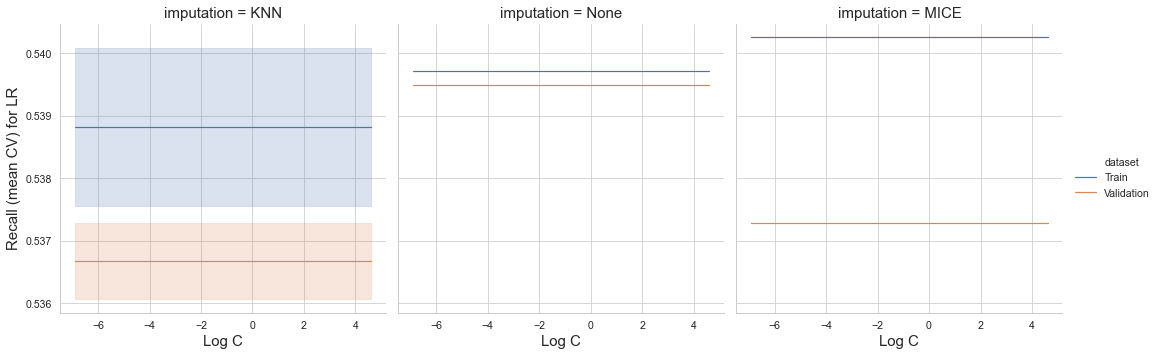

In [98]:
# figure of model comparisons on training  
g = sns.relplot(data = recall_results[recall_results.model == "Logistic Regression"],
                x = "log_C", y = 'score', 
                color = "black", hue = "dataset", 
                kind = "line", col = "imputation")
g.set_xlabels("Log C", size = 15)
g.set_ylabels("Recall (mean CV) for LR", size = 15)
g.set_titles(size = 15)

plt.savefig('../figures/NCDB_selected_features_results/grid_CV_recall_L.png', bbox_inches = 'tight')

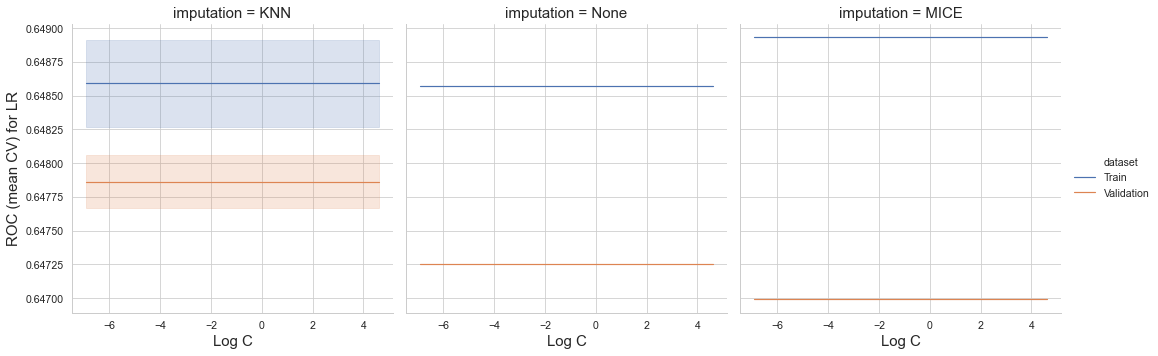

In [100]:
# figure of model comparisons on training  
g = sns.relplot(data = roc_auc_score_results[roc_auc_score_results.model == "Logistic Regression"],
                x = "log_C", y = 'score', 
                color = "black", hue = "dataset", 
                kind = "line", col = "imputation")
g.set_xlabels("Log C", size = 15)
g.set_ylabels("ROC (mean CV) for LR", size = 15)
g.set_titles(size = 15)

plt.savefig('../figures/NCDB_selected_features_results/grid_CV_ROC_LR.png', bbox_inches = 'tight')

###  Support Vector Machine tuning

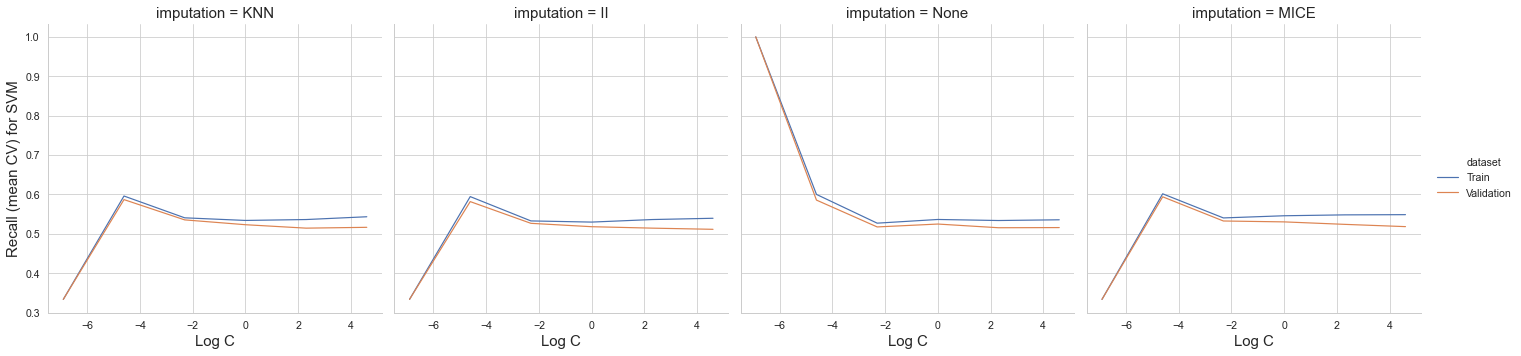

In [86]:
# figure of model comparisons on training  
g = sns.relplot(data = recall_results[recall_results.model == "Support Vector Machine"],
                x = "log_C", y = 'score', 
                color = "black", hue = "dataset", 
                kind = "line", col = "imputation")
g.set_xlabels("Log C", size = 15)
g.set_ylabels("Recall (mean CV) for SVM", size = 15)
g.set_titles(size = 15)

plt.savefig('../figures/NCDB_selected_features_results/grid_CV_recall_SVM.png', bbox_inches = 'tight')

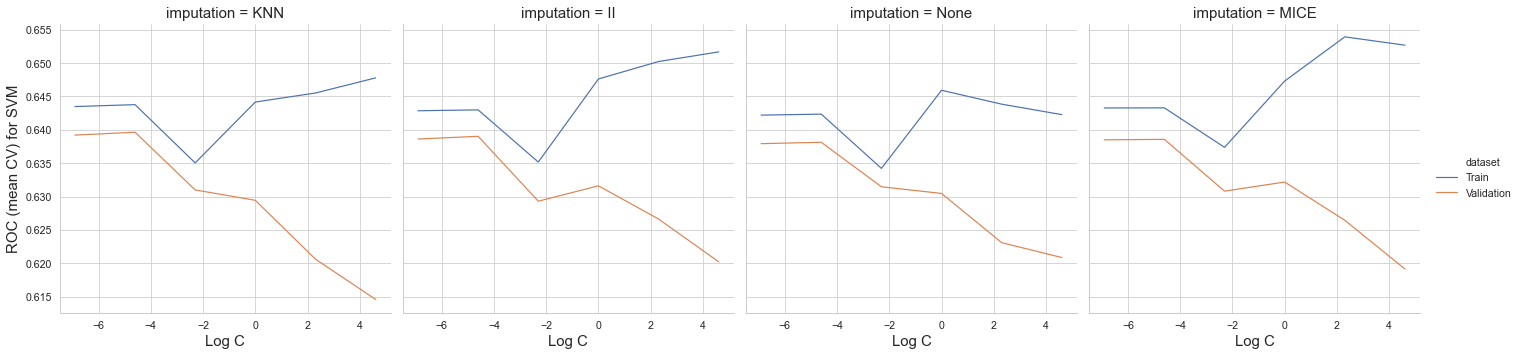

In [96]:
# figure of model comparisons on training  
g = sns.relplot(data = roc_auc_score_results[roc_auc_score_results.model == "Support Vector Machine"],
                x = "log_C", y = 'score', 
                color = "black", hue = "dataset", 
                kind = "line", col = "imputation")
g.set_xlabels("Log C", size = 15)
g.set_ylabels("ROC (mean CV) for SVM", size = 15)
g.set_titles(size = 15)

plt.savefig('../figures/NCDB_selected_features_results/grid_CV_ROC_SVM.png', bbox_inches = 'tight')

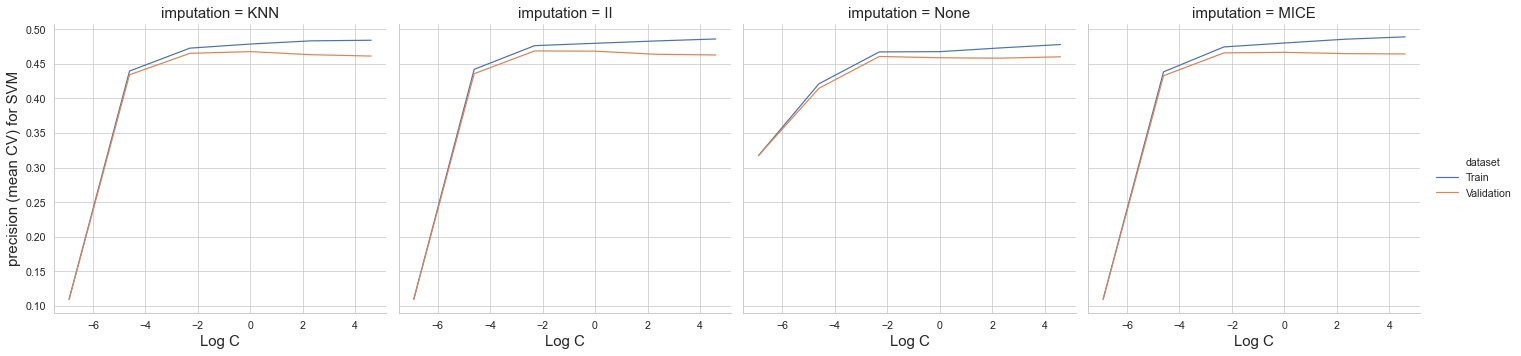

In [88]:
# figure of model comparisons on training  
g = sns.relplot(data = precision_results[precision_results.model == "Support Vector Machine"],
                x = "log_C", y = 'score', 
                color = "black", hue = "dataset", 
                kind = "line", col = "imputation")
g.set_xlabels("Log C", size = 15)
g.set_ylabels("precision (mean CV) for SVM", size = 15)
g.set_titles(size = 15)

plt.savefig('../figures/NCDB_selected_features_results/grid_CV_precision_SVM.png', bbox_inches = 'tight')

### Decision tree model tuning

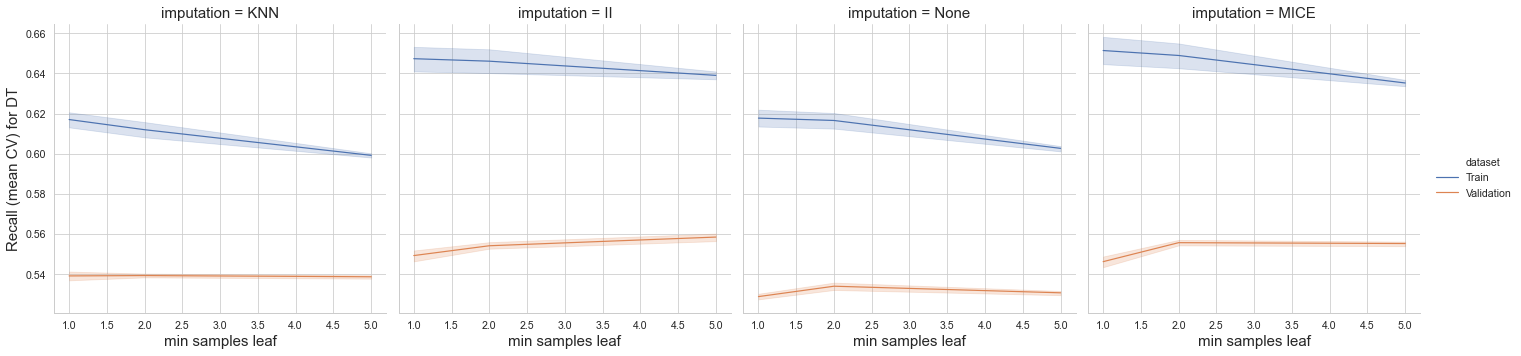

In [95]:
# figure of model comparisons on training  
g = sns.relplot(data = recall_results[recall_results.model == "Decision Tree"],
                x = "param_model__min_samples_leaf", y = 'score', 
                color = "black", hue = "dataset", 
                kind = "line", col = "imputation") #, row = "param_model__min_samples_split")
g.set_xlabels("min samples leaf", size = 15)
g.set_ylabels("Recall (mean CV) for DT", size = 15)
g.set_titles(size = 15)

plt.savefig('../figures/NCDB_selected_features_results/grid_CV_recall_DT.png', bbox_inches = 'tight')

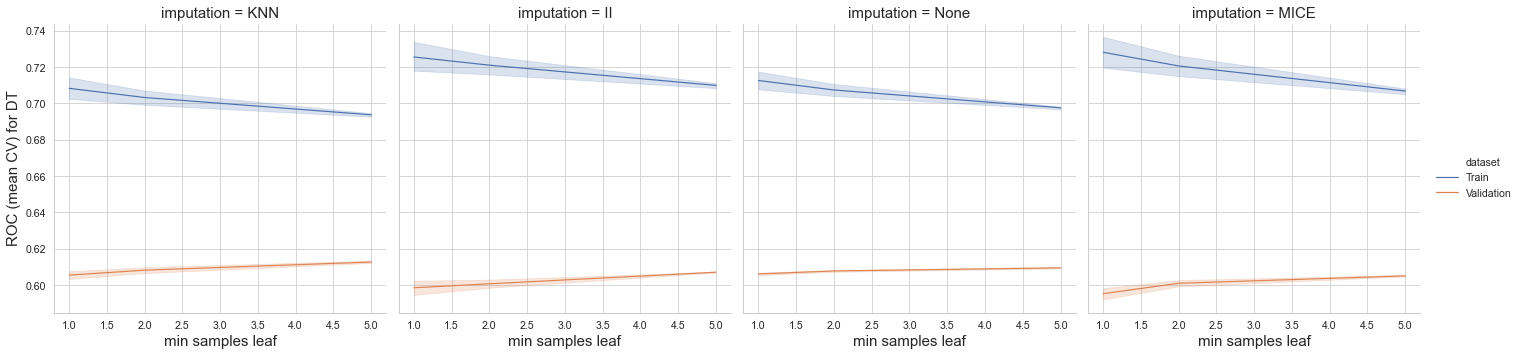

In [97]:
# figure of model comparisons on training  
g = sns.relplot(data = roc_auc_score_results[roc_auc_score_results.model == "Decision Tree"],
                x = "param_model__min_samples_leaf", y = 'score', 
                color = "black", hue = "dataset", 
                kind = "line", col = "imputation") #, row = "param_model__min_samples_split")
g.set_xlabels("min samples leaf", size = 15)
g.set_ylabels("ROC (mean CV) for DT", size = 15)
g.set_titles(size = 15)

plt.savefig('../figures/NCDB_selected_features_results/grid_CV_ROC_DT.png', bbox_inches = 'tight')

### Random forest model tuning 

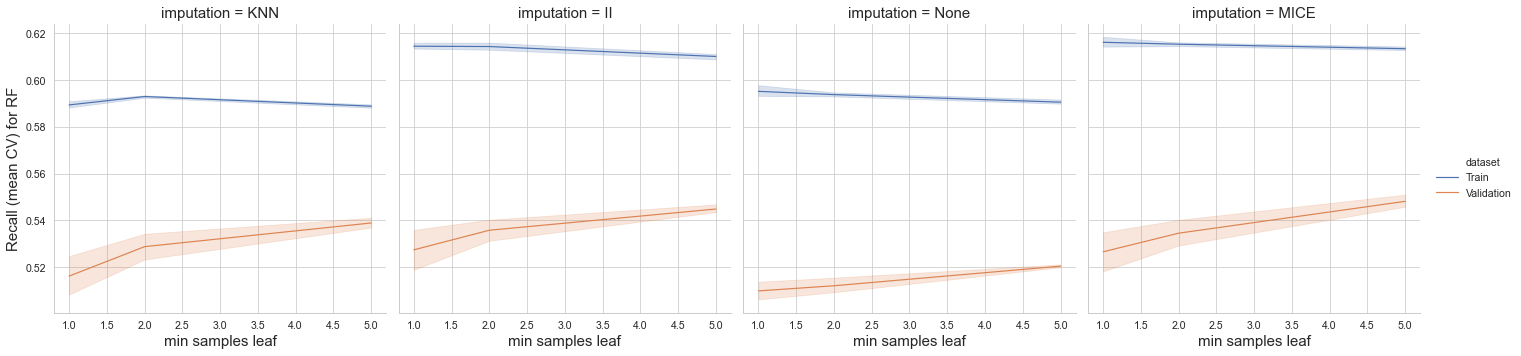

In [93]:
# figure of model comparisons on training  
g = sns.relplot(data = recall_results[recall_results.model == "Random Forest"],
                x = "param_model__min_samples_leaf", y = 'score', 
                color = "black", hue = "dataset", 
                kind = "line", col = "imputation") #, row = "param_model__min_samples_split")
g.set_xlabels("min samples leaf", size = 15)
g.set_ylabels("Recall (mean CV) for RF", size = 15)
g.set_titles(size = 15)

plt.savefig('../figures/NCDB_selected_features_results/grid_CV_recall_RF.png', bbox_inches = 'tight')

### 3.5 Compare model performance on validation sets

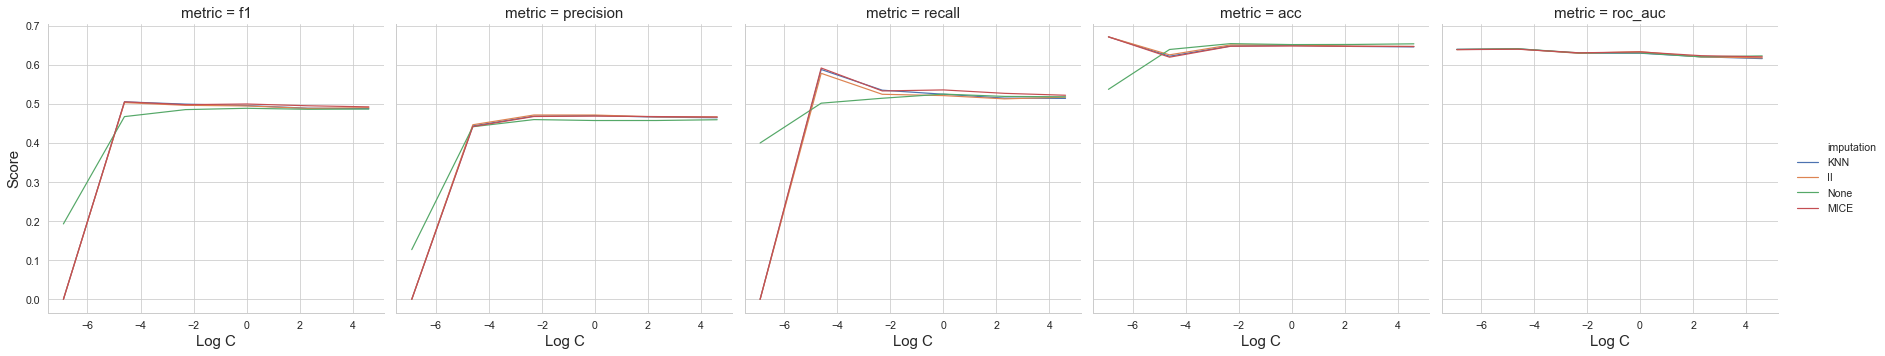

In [290]:
subset_results = grid_results_long[(grid_results_long.dataset == "Validation")
                                         & (grid_results_long.model == "Lasso")]

g = sns.relplot(data = subset_results, 
                x = "log_C", y = "score", 
                hue = "imputation", col = "metric",
                kind = "line")
g.set_xlabels("Log C", size = 15)
g.set_ylabels("Score", size = 15)
g.set_titles(size = 15)

## 4. Evaluate the best model
- fit the final model, with all of the training data
- run on hold-out test data.

###  find best model from all grids
- using RECALL

In [106]:
best_metric = grid_results['mean_test_recall'].max()
print("Best Recall %0.4f" % best_metric)
best_model = grid_results[grid_results.mean_test_recall == best_metric]
display(best_model.model)
display(best_model.param_model__C)
display(best_model.imputation)
# how are all three imputation results idenitcal?
# for now, just chose iterative imputer 

Best Recall 0.5867


7    Support Vector Machine
Name: model, dtype: object

7    0.01
Name: param_model__C, dtype: object

7    KNN
Name: imputation, dtype: object

###   Fit the best model on test data

In [103]:
# define and fit the model 
# try regular model
best_LR_model = LogisticRegression(class_weight = 'balanced', 
                                   max_iter = 1000,
                                    penalty = 'none', solver = 'saga')


#best_LR_model = LogisticRegression(class_weight = 'balanced', 
 #                                penalty = 'elasticnet',
  #                               solver = 'saga', 
   #                              l1_ratio = 0.05,
    #                             C = 1,
     #                            max_iter = 1000, 
      #                           random_state = RANDOM)
# which version of data
y_test = y_test_drop
y_trainval = y_trainval_drop
X_trainval = X_trainval_drop
X_test = X_test_drop

# applying the preprocessing to the X_trainval and X_test 
preproc_X_trainval = SS_preprocessor.fit_transform(X_trainval)
preproc_X_test = SS_preprocessor.fit_transform(X_test)

# fit the model to the entire train-validation set
best_LR_model.fit(preproc_X_trainval, y_trainval)

# confirming that sklearn adds an intercept! 
best_LR_model.intercept_


/Users/michellevantieghem2/.conda/envs/insight/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


array([-0.42832135])

### get model scores

In [107]:
y_pred = best_LR_model.predict(preproc_X_test)

# get scores 
best_test_scores = pd.DataFrame({ "metrics"  : ["precision", "recall", "roc_auc", "accuracy", "f1 score"],
                            "scores" : [precision_score(y_test, y_pred), 
                                       recall_score(y_test, y_pred),
                                        roc_auc_score(y_test, y_pred),
                                        accuracy_score(y_test, y_pred),
                                       f1_score(y_test, y_pred)]
                           })
best_test_scores['scores'] = best_test_scores.scores.round(3)

print("Best Model scores on hold-out test set")
display(best_test_scores)# define and fit the model 


Best Model scores on hold-out test set


,metrics,scores
0,precision,0.512
1,recall,0.559
2,roc_auc,0.631
3,accuracy,0.651
4,f1 score,0.535


### Get predicted probabilities

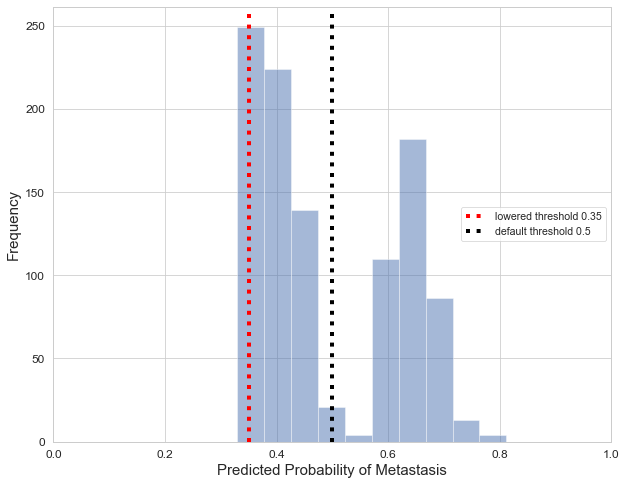

In [108]:
# get predictions on hold-out test set.
y_pred_prob = pd.DataFrame(best_LR_model.predict_proba(preproc_X_test))[1]
key_thresh = 0.35
custom_funcs.plot_predprobs(y_pred_prob, key_thresh)


### 4.3 Inspect the confusion matrix


../projectname/custom_funcs.py:219: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+['No Mets', 'Mets'])
../projectname/custom_funcs.py:220: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+['No mets', 'Mets'])


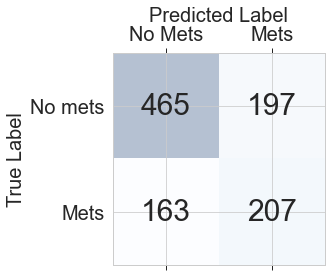

True negatives identified: Proportion of sample correctly identified  as low risk, no biopsy necessary: 0.45
True positives identified: Proportion of sample correctly classified as high risk, need biopsy: 0.2
Recall / Sensitivity: 
 Of all people who actually have metastasis, how many are correctly recommended for biopsy? 0.56
False negative rate: 
 Patients mis-classified as low risk, but need biopsy: 0.44

 Specificity/True negative rate: 
 Of people who are actually low risk, how many are classified as low risk? 0.7
False positive rate: 
 Patients classifiedas high risk, but don't need biopsy: 0.3
Precision / Positive Predictive Value: 
 Of all people recommended for biopsy, how many actually have metastasis? 0.51
Negative Predictive Value: 
 Of people classified as low risk,  how many are actually low risk? 1


In [109]:
# get our predictions on the test dataset for conversion = 1 or 0

cm = confusion_matrix(y_test, y_pred)
custom_funcs.pretty_cm(cm, "../figures/NCDB_selected_features_results/confusion_matrix_0.5.png")
custom_funcs.get_cm_info(cm, y_test) 

### Calibrate predicted probabilities

/Users/michellevantieghem2/.conda/envs/insight/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


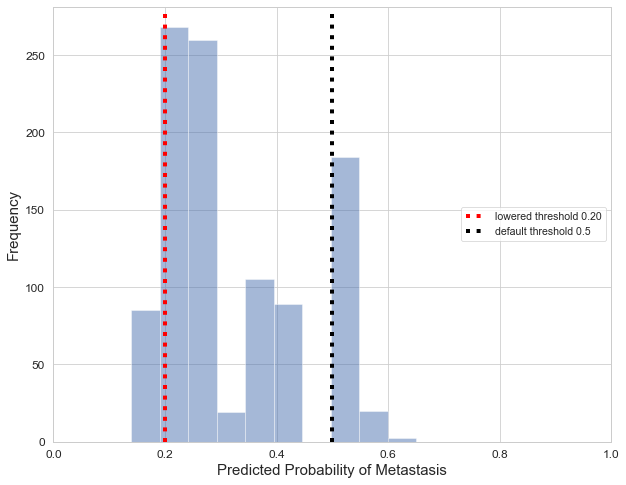

In [110]:
from sklearn.calibration import CalibratedClassifierCV

platts_scaling = CalibratedClassifierCV(best_LR_model, cv=2, method='isotonic')
platts_scaling.fit(preproc_X_trainval, y_trainval)
calibrated_probs = platts_scaling.predict_proba(preproc_X_test)[:,1]

#custom_funcs.plot_calibration_curve(best_LR_model, "Lasso Regression", 1, 
 #                                   preproc_X_trainval, preproc_X_test, y_trainval, y_test)
key_thresh = 0.2
custom_funcs.plot_predprobs(calibrated_probs, key_thresh)


### lower decision-boundary

../projectname/custom_funcs.py:219: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+['No Mets', 'Mets'])
../projectname/custom_funcs.py:220: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+['No mets', 'Mets'])


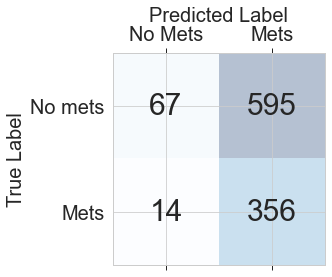

True negatives identified: Proportion of sample correctly identified  as low risk, no biopsy necessary: 0.06
True positives identified: Proportion of sample correctly classified as high risk, need biopsy: 0.34

 Recall / Sensitivity: 
 Of all people who actually have metastasis, how many are correctly recommended for biopsy? 0.96
False negative rate: 
 Patients mis-classified as low risk, but need biopsy: 0.04

 Specificity/True negative rate: 
 Of people who are actually low risk, how many are classified as low risk? 0.1
False positive rate: 
 Patients classifiedas high risk, but don't need biopsy: 0.9

 Precision / Positive Predictive Value: 
 Of all people recommended for biopsy, how many actually have metastasis? 0.37
Negative Predictive Value: 
 Of people classified as low risk,  how many are actually low risk? 1


In [111]:
key_thresh = 0.18
y_pred_thresh_lower = calibrated_probs >  key_thresh
cm = confusion_matrix(y_test, y_pred_thresh_lower)
custom_funcs.pretty_cm(cm, "../figures/NCDB_selected_features_results/confusion_matrix_0.4.png")
get_cm_info(cm, y_pred_thresh_lower)

### More informative plots

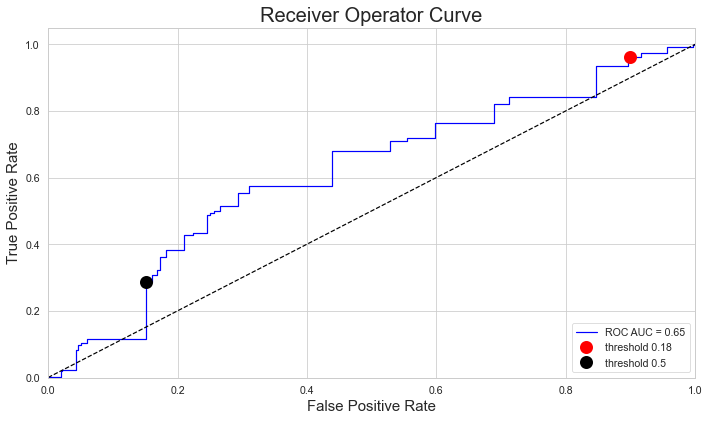

In [112]:
custom_funcs.plot_roc_curve(y_test, calibrated_probs, key_thresh)

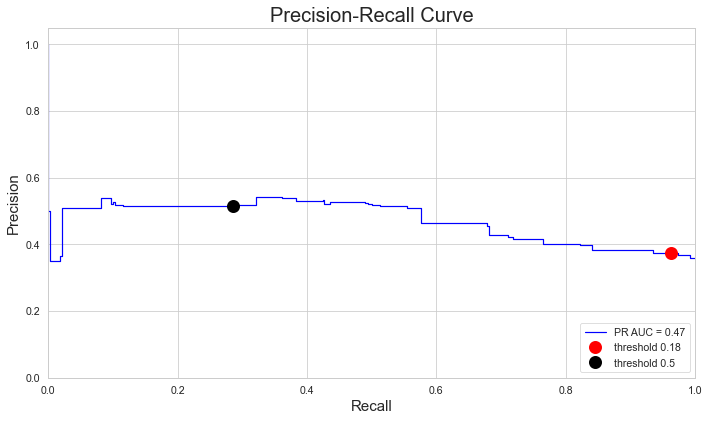

In [113]:
custom_funcs.plot_pr_curve(y_test, calibrated_probs, key_thresh)

### 4.6 Feature importance

In [114]:
preproc_X_test_df = pd.DataFrame(preproc_X_test)
# apply the function to  get the featture names, because preprocessor mixes up order.
preproc_feature_names = custom_funcs.get_feature_names(SS_preprocessor)
# check output!! 
preproc_feature_names

../projectname/custom_funcs.py:266: UserWarning: Transformer std_scaler (type StandardScaler) does not provide get_feature_names. Will return input column names if available
  % (str(name), type(trans).__name__))


['num__AGE', 'num__tumor_size_bins_cm', 'lymph_vasc_invasion']

In [115]:
prettier_names = ['Age', 'Tumor size (cm)',  'Lymph vascular invasion']
preproc_X_test_df.columns = prettier_names
# apply custom function to get coefficients from model 
coefs_df = custom_funcs.get_ordered_coefs(best_LR_model, preproc_X_test_df)


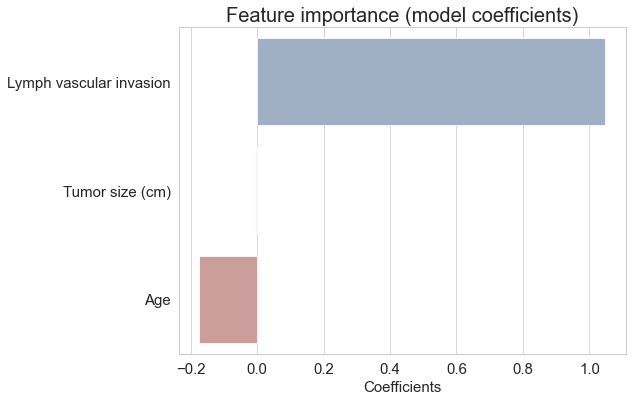

In [116]:
n_features =  coefs_df.shape[0]
plt.figure(figsize =  (8,6))
g = sns.barplot(data = coefs_df, y = 'features', x = "coefs",
            palette = sns.color_palette("vlag", n_features))
g.set_ylabel("")
g.tick_params(labelsize = 15)
g.set_xlabel("Coefficients", size = 15)
g.set_title("Feature importance (model coefficients)", size = 20);
plt.savefig('../figures/NCDB_selected_features_results/best_LR_feature_weights.png', bbox_inches = 'tight')